In [1]:
# Import necessary libraries

import tensorflow as tf
import numpy as np
import h5py
import os
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import SimpleITK as sitk  # For bias field correction

In [2]:
# Define paths for the training and validation datasets
train_dirs = [
    r"/kaggle/input/brats2020-6k-images/BraTS2020_6K/Training/1",
    r"/kaggle/input/brats2020-6k-images/BraTS2020_6K/Training/2",
    r"/kaggle/input/brats2020-6k-images/BraTS2020_6K/Training/3"
]
validation_dir = r"/kaggle/input/brats2020-6k-images/BraTS2020_6K/Validation"
model_save_paths = [
    r"/kaggle/working/unet_model_1.keras",
    r"/kaggle/working/unet_model_2.keras",
    r"/kaggle/working/unet_model_3.keras"
]

In [3]:
# Function for Bias Field Correction
def bias_field_correction(image):
    # Convert the NumPy array to a SimpleITK image for correction
    sitk_image = sitk.GetImageFromArray(image.squeeze())
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected_image = corrector.Execute(sitk_image)
    # Convert back to NumPy array
    return sitk.GetArrayFromImage(corrected_image).reshape(image.shape)

In [4]:
# Function to load images and masks from a directory
def load_data(images_dir):
    images = []
    masks = []
    for file_name in os.listdir(images_dir):
        # Only process HDF5 files
        if file_name.endswith('.h5'):
            image_path = os.path.join(images_dir, file_name)
            img = load_and_preprocess_image(image_path)
            images.append(img)
            # Create mask based on file naming (1 for '1', 0 otherwise)
            mask = np.ones((128, 128, 1)) if '1' in file_name else np.zeros((128, 128, 1))
            masks.append(mask)
    return np.array(images), np.array(masks)

In [5]:
# Data augmentation function
def augment_data(images, masks):
    # Define augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    augmented_images, augmented_masks = [], []
    for img, mask in zip(images, masks):
        img, mask = img.reshape((1,) + img.shape), mask.reshape((1,) + mask.shape)
        # Apply augmentation and limit to original dataset size
        for img_batch, mask_batch in zip(datagen.flow(img, batch_size=1), datagen.flow(mask, batch_size=1)):
            augmented_images.append(img_batch[0])
            augmented_masks.append(mask_batch[0])
            if len(augmented_images) >= len(images): break
    return np.array(augmented_images), np.array(augmented_masks)

In [6]:
# Image preprocessing function
def load_and_preprocess_image(image_path):
    # Load image from HDF5 file
    with h5py.File(image_path, 'r') as f:
        img = np.array(f['image'])
    # Convert multi-channel image to grayscale
    if img.shape[-1] != 1:
        img = np.mean(img, axis=-1, keepdims=True)
    # Apply bias field correction
    img = bias_field_correction(img)
    # Resize image and normalize
    img = tf.image.resize(img, (128, 128))
    img = np.clip(img, 0, 255) / 255.0  # Normalize to [0, 1]
    return img

In [7]:
# U-Net model with dilation layers
def unet_model_with_dilation(input_size=(128, 128, 1)):
    inputs = tf.keras.layers.Input(input_size)

    # Downsampling with dilation in initial layers
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', dilation_rate=2)(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck with higher dilation
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', dilation_rate=4)(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Upsampling without dilation
    up4 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = tf.keras.layers.Concatenate()([up4, conv2])
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = tf.keras.layers.Concatenate()([up5, conv1])
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer with sigmoid activation for binary classification
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv5)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
# Function to train and save the model
"""def train_and_save_model(train_dir, model_save_path):
    # Load and augment training data
    images, masks = load_data(train_dir)
    augmented_images, augmented_masks = augment_data(images, masks)
    # Initialize and compile the model
    model = unet_model_with_dilation()
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    # Train the model
    model.fit(augmented_images, augmented_masks, epochs=30, batch_size=16, validation_split=0.2)
    # Save the trained model
    model_save_path = r"/kaggle/working/unet_model.keras"
    model.save(model_save_path)"""

# Function to train and save the model
def train_and_save_model(train_dir, model_save_path):
    # Load and augment training data
    images, masks = load_data(train_dir)
    augmented_images, augmented_masks = augment_data(images, masks)
    # Initialize and compile the model
    model = unet_model_with_dilation()
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    # Train the model
    model.fit(augmented_images, augmented_masks, epochs=1, batch_size=16, validation_split=0.2)

    # Try saving the model
    try:
        model.save('/kaggle/working/unet_model.keras')
        print("Model saved successfully.")
    except Exception as e:
        print(f"Error while saving the model: {e}")

    # List files in the working directory
    import os
    print(os.listdir('/kaggle/working/'))

    # Save the trained model
    #model_save_path = '/kaggle/input/brats2020-6k-images/unet_model.keras'
    model.save(model_save_path)

In [9]:
# Train and save a separate model for each training dataset
for train_dir, model_save_path in zip(train_dirs, model_save_paths):
    train_and_save_model(train_dir, model_save_path)

I0000 00:00:1733180056.301876     379 service.cc:145] XLA service 0x7948880095b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733180056.301932     379 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/200 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.8854 - loss: 0.6931

I0000 00:00:1733180065.630445     379 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8569 - loss: 0.6915

I0000 00:00:1733180085.341605     379 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_bitcast_reduce_fusion', 4 bytes spill stores, 4 bytes spill loads



200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.8569 - loss: 0.6915 - val_accuracy: 0.6250 - val_loss: 0.6908
Model saved successfully.
['.virtual_documents', 'unet_model.keras']
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.8787 - loss: 0.6913 - val_accuracy: 0.6800 - val_loss: 0.6897
Model saved successfully.
['.virtual_documents', 'unet_model_1.keras', 'unet_model.keras']
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.8530 - loss: 0.6914 - val_accuracy: 0.6438 - val_loss: 0.6904
Model saved successfully.
['.virtual_documents', 'unet_model_1.keras', 'unet_model.keras', 'unet_model_2.keras']


In [10]:
# Load and validate models
def load_model(model_path):
    # Load a trained model from a given path
    return tf.keras.models.load_model(model_path)

In [11]:
# Validate each model on the validation dataset
def validate_models(validation_dir, model_paths):
    validation_images, validation_masks = load_data(validation_dir)
    for model_path in model_paths:
        model = load_model(model_path)
        # Evaluate model on validation data
        loss, accuracy = model.evaluate(validation_images, validation_masks)
        print(f"Model {model_path} - Loss: {loss}, Accuracy: {accuracy}")

In [12]:
# Perform validation
validate_models(validation_dir, model_save_paths)

from skimage.metrics import hausdorff_distance  # For Hausdorff distance calculation
import SimpleITK as sitk  # For bias field correction

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3000 - loss: 0.6971
Model /kaggle/working/unet_model_1.keras - Loss: 0.6970615386962891, Accuracy: 0.30000001192092896
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step - accuracy: 0.3000 - loss: 0.6971
Model /kaggle/working/unet_model_2.keras - Loss: 0.697105348110199, Accuracy: 0.30000001192092896
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step - accuracy: 0.3000 - loss: 0.6971
Model /kaggle/working/unet_model_3.keras - Loss: 0.6971305012702942, Accuracy: 0.30000001192092896


In [13]:
# Define paths for validation dataset and metadata
#validation_dir = r"E:\Code_Dataset\Validation"
validation_dir = r"/kaggle/input/brats2020-6k-images/BraTS2020_6K/Validation"

validation_dir = r"/kaggle/input/validation-dataset-1"
#validation_meta_data_path = r"/kaggle/input/brats2020-6k-images/BraTS2020_6K/Validation/metadata_val.csv"
validation_meta_data_path = r"/kaggle/input/metadata-val/metadata_val.csv"
validation_meta_data_path = r"/kaggle/input/validation-meta-data-1/metadata_val_1.csv"

In [14]:
# Load metadata from CSV file
validation_metadata = pd.read_csv(validation_meta_data_path)

In [15]:
# Function for Bias Field Correction
def bias_field_correction(image):
    # Convert the image to SimpleITK format for correction
    sitk_image = sitk.GetImageFromArray(image.squeeze())
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected_image = corrector.Execute(sitk_image)
    # Convert the corrected image back to NumPy array format
    return sitk.GetArrayFromImage(corrected_image).reshape(image.shape)

In [16]:
# Image preprocessing function
def load_and_preprocess_image(image_path):
    # Load image from HDF5 file
    with h5py.File(image_path, 'r') as f:
        img = np.array(f['image'])
    # Convert multi-channel image to grayscale if necessary
    if img.shape[-1] != 1:
        img = np.mean(img, axis=-1, keepdims=True)
    # Apply bias field correction
    img = bias_field_correction(img)
    # Resize image to 128x128 and normalize pixel values
    img = tf.image.resize(img, (128, 128))
    img = np.clip(img, 0, 255) / 255.0  # Normalize to [0, 1]
    return img

In [17]:
# Function to load validation images and masks based on metadata
def load_validation_data(validation_dir, validation_metadata):
    images = []
    masks = []
    for idx, row in validation_metadata.iterrows():
        # Construct full image path
        image_path = os.path.join(validation_dir, row['slice_path'])

        # Check if the file exists; skip if not found
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            continue

        # Load and preprocess the image
        img = load_and_preprocess_image(image_path)
        images.append(img)

        # Create mask based on 'target' value in metadata (1 or 0)
        mask = np.ones((128, 128, 1)) if row['target'] == 1 else np.zeros((128, 128, 1))
        masks.append(mask)

    # Return images and masks as arrays
    return np.array(images), np.array(masks)

In [18]:
print(validation_dir)
print(validation_metadata)

/kaggle/input/validation-dataset-1
                                          slice_path  target  volume  slice
0  /kaggle/input/validation-dataset-1/volume_15_s...       0      15     30
1  /kaggle/input/validation-dataset-1/volume_15_s...       0      15     31
2  /kaggle/input/validation-dataset-1/volume_15_s...       0      15     32
3  /kaggle/input/validation-dataset-1/volume_15_s...       0      15     33
4  /kaggle/input/validation-dataset-1/volume_15_s...       0      15     34


In [19]:
# Load validation images and masks
val_images, val_masks = load_validation_data(validation_dir, validation_metadata)

In [20]:
# Load the saved model for making predictions
model = tf.keras.models.load_model(model_save_path)

In [21]:
# Make predictions on validation images
predictions = model.predict(val_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [22]:
# Function to calculate Intersection over Union (IoU) metric
def calculate_iou(y_true, y_pred):
    # Compute intersection and union
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    # Calculate IoU as the ratio of intersection to union
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [23]:
# Function to calculate Dice Similarity Coefficient
def calculate_dice(y_true, y_pred):
    # Calculate Dice score using the intersection
    intersection = np.sum(y_true * y_pred)
    dice_score = (2 * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_score

In [24]:
# Function to calculate Hausdorff Distance
def calculate_hausdorff(y_true, y_pred):
    # Hausdorff distance between true and predicted masks
    return hausdorff_distance(y_true.squeeze(), y_pred.squeeze())

In [25]:
# Initialize lists to store metrics
iou_scores = []
dice_scores = []
hausdorff_distances = []

In [26]:
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return 0  # or np.nan if you want to skip these cases in analysis
    return intersection / union

def calculate_dice(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    denominator = y_true.sum() + y_pred.sum()
    if denominator == 0:
        return 0  # or np.nan if you prefer
    return (2 * intersection) / denominator

for i in range(len(val_masks)):
    y_true = val_masks[i]
    y_pred = (predictions[i] > 0.5).astype(int)

    if np.sum(y_true) == 0 and np.sum(y_pred) == 0:
        print(f"Skipping image {i} due to no foreground in both masks.")
        continue

    iou = calculate_iou(y_true, y_pred)
    dice = calculate_dice(y_true, y_pred)
    hausdorff = calculate_hausdorff(y_true, y_pred)

    iou_scores.append(iou)
    dice_scores.append(dice)
    hausdorff_distances.append(hausdorff)


Skipping image 0 due to no foreground in both masks.
Skipping image 1 due to no foreground in both masks.
Skipping image 2 due to no foreground in both masks.
Skipping image 3 due to no foreground in both masks.
Skipping image 4 due to no foreground in both masks.


In [27]:
# Evaluate metrics on each image-mask pair in validation set
for i in range(len(val_masks)):
    y_true = val_masks[i]
    y_pred = (predictions[i] > 0.5).astype(int)  # Binarize prediction at threshold 0.5

    # Calculate metrics
    iou = calculate_iou(y_true, y_pred)
    dice = calculate_dice(y_true, y_pred)
    hausdorff = calculate_hausdorff(y_true, y_pred)

    # Append metrics to their respective lists
    iou_scores.append(iou)
    dice_scores.append(dice)
    hausdorff_distances.append(hausdorff)

In [28]:
# Print average of each metric across the validation set
print("Average IoU:", np.mean(iou_scores))
print("Average Dice Similarity Coefficient:", np.mean(dice_scores))
print("Average Hausdorff Distance:", np.mean(hausdorff_distances))

Average IoU: 0.0
Average Dice Similarity Coefficient: 0.0
Average Hausdorff Distance: 0.0


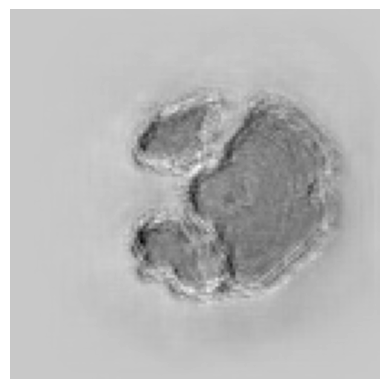

In [29]:
import matplotlib.pyplot as plt

pred = predictions[3]
# Assuming pred is a NumPy array representing the image
plt.imshow(pred, cmap='gray')  # Remove cmap='gray' for color images
plt.axis('off')  # Hides the axes
plt.show()


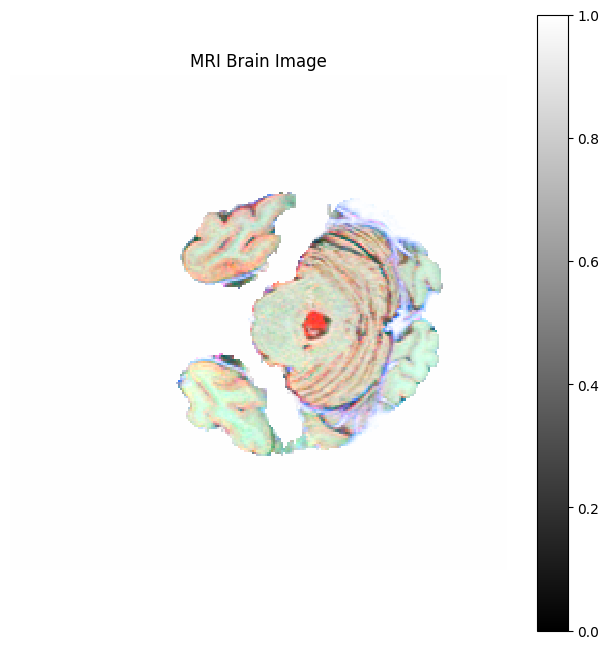

In [30]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Open the HDF5 file
with h5py.File('/kaggle/input/validation-dataset-1/volume_15_slice_33.h5', 'r') as f:
    # Assuming the image data is stored in a dataset named 'image'
    image_data = f['image'][:]

# Ensure the data is in floating point for processing
image_data = image_data.astype(np.float32)

# Optionally, clip extreme values for better contrast (adjust percentile as needed)
p_low, p_high = np.percentile(image_data, (1, 99))  # 1st and 99th percentile
image_data = np.clip(image_data, p_low, p_high)

# Normalize data to [0, 1] for display
image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

# Display the image using a medically suitable grayscale colormap
plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray', interpolation='nearest')
plt.axis('off')  # Turn off axis for better focus on the image
plt.title('MRI Brain Image')
plt.colorbar()  # Add colorbar to show intensity scale
plt.show()
